In [1]:
!pip install linformer

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from linformer import Linformer
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy
import math


Extracting ./data/cifar-10-python.tar.gz to ./data
torch.Size([64, 3, 32, 32])
tensor(1.) tensor(-1.)


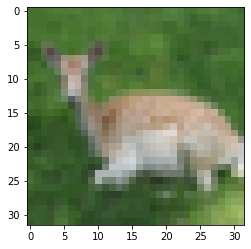

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, num_workers=2, shuffle = True)

data_loader = iter(trainloader)
(data, target) = next(data_loader)

print(data.shape)
print(data.max(), data.min())
img = np.transpose(data[0], (1, 2, 0))
plt.imshow((img+1)/2)
plt.show()

In [4]:
class ModNet(nn.Module):
  def __init__(self, channels, noise_dim):
    super(ModNet, self).__init__()

    self.F = nn.Linear(noise_dim, noise_dim)
    self.M, self.S = nn.Linear(noise_dim, channels), nn.Linear(noise_dim, channels)

  def forward(self, x, z):
    mu = x.mean(dim = (2, 3), keepdim = True)
    sig = x.var(dim = (2, 3), keepdim = True).sqrt()
    x = (x-mu)/sig

    z = F.leaky_relu(self.F(z))
    g, b = self.M(z).unsqueeze(-1).unsqueeze(-1), self.S(z).unsqueeze(-1).unsqueeze(-1)
    x = g*x + b
    return x

class Res_Block(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(Res_Block, self).__init__()
    self.C1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
    self.C2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
    self.CS = nn.Conv2d(in_channels, out_channels, 1)

    #self.C1.weight.data.normal_(0.0, 0.02)
    #self.C2.weight.data.normal_(0.0, 0.02)
    self.CS.weight.data.normal_(0.0, 0.02)
    nn.init.orthogonal_(C1.weight)
    nn.init.orthogonal_(C2.weight)
    self.C1 = nn.utils.spectral_norm(self.C1)
    self.C2 = nn.utils.spectral_norm(self.C2)
    self.CS = nn.utils.spectral_norm(self.CS)

  def forward(self, x):
    xs = self.CS(x)

    x = F.leaky_relu(self.C1(x))
    x = F.leaky_relu(xs + self.C2(x))
    return x


class Basic_Gen(nn.Module):
  def __init__(self, image_size = (32, 32), noise_dim = 128):
    super(Basic_Gen, self).__init__()
    self.h, self.w = image_size[0]//8, image_size[1]//8
    self.Proj = nn.Linear(noise_dim, 256*self.h*self.w)
    self.BN0 = ModNet(256, noise_dim)

    self.RGB0 = nn.Conv2d(256, 3, 1) 
    self.RGB0.weight.data.normal_(0, 0.02)
    self.RGB0 = nn.utils.spectral_norm(self.RGB0)

    self.no_of_layers = 3
    self.C, self.C2, self.C3, self.RGB, self.MN, self.MN2 = [], [], [], [], [], []
    self.R, self.R2 = [], []

    for i in range(self.no_of_layers):
      C = nn.Conv2d(256, 256, 3, 1, 1)
      C2 = nn.Conv2d(256, 256, 3, 1, 1)
      RGB = nn.Conv2d(256, 3, 1)
      MN = ModNet(256, noise_dim)
      MN2 = ModNet(256, noise_dim)

      RGB.weight.data.normal_(0, 0.02)
      #C.weight.data.normal_(0, 0.02)
      #C2.weight.data.normal_(0, 0.02)
      nn.init.orthogonal_(C.weight)
      nn.init.orthogonal_(C2.weight)
      C = nn.utils.spectral_norm(C)
      C2 = nn.utils.spectral_norm(C2)
      RGB = nn.utils.spectral_norm(RGB)

      self.C.append(C)
      self.C2.append(C2)
      self.RGB.append(RGB)
      self.MN.append(MN)
      self.MN2.append(MN2)

    self.C, self.RGB = nn.ModuleList(self.C), nn.ModuleList(self.RGB)
    self.C2, self.MN, self.MN2 = nn.ModuleList(self.C2), nn.ModuleList(self.MN), nn.ModuleList(self.MN2)
    
    self.CF1 = nn.Conv2d(256, 256, 3, 1, 1)
    self.CF2 = nn.Conv2d(256, 256, 3, 1, 1)
    self.CF = nn.Conv2d(256, 3, 1)
    self.CF1.weight.data.normal_(0, 0.02)
    self.CF2.weight.data.normal_(0, 0.02)
    self.CF.weight.data.normal_(0, 0.02)
    self.CF = nn.utils.spectral_norm(self.CF)
    self.CF1 = nn.utils.spectral_norm(self.CF1)
    self.CF2 = nn.utils.spectral_norm(self.CF2)


    self.BNF1 = ModNet(256, noise_dim)
    self.BNF2 = ModNet(256, noise_dim)

  def forward(self, z):
    x = self.Proj(z)
    x = x.view(-1, 256, self.h, self.w)
    x = self.BN0(x, z)
    x = F.leaky_relu(x)
    o = self.RGB0(x)

    for i in range(self.no_of_layers):
      x = self.C[i](x)
      x = self.MN[i](x, z)
      x = F.leaky_relu(x)
      x = self.C2[i](x)
      x = self.MN2[i](x, z)
      x = F.leaky_relu(x)

      o = o + self.RGB[i](x)
      x = F.interpolate(x, scale_factor = 2, mode = 'bilinear')
      o = F.interpolate(o, scale_factor = 2, mode = 'bilinear')

    x = F.leaky_relu(self.BNF1(self.CF1(x), z))
    x = F.leaky_relu(self.BNF2(self.CF1(x), z))
    x = torch.tanh(o + self.CF(x))
    #x = torch.tanh(self.CF(x))
    return x


class PositionalEncoding(nn.Module):
    def __init__(self, k, max_len = 5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, k)
        position = torch.arange(0, max_len, dtype = torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, k, 2).float() * (-math.log(10000.0)/k))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    
    def forward(self, x):  
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class Transformer(nn.Module):
    def __init__(self, k, n_classes):
        super(Transformer, self).__init__()
        self.k = k
        
        self.linear_proj = nn.Linear(k, k, bias=False)
        self.pos_encoder = PositionalEncoding(k)

        efficient_transformer = Linformer(
            dim=k,
            seq_len=16,
            depth=12,
            heads=8,
            k=64
        )
        #encoder_layers = nn.TransformerEncoderLayer(k, 8, k, activation='relu')
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layers, 6)
        self.transformer_encoder = efficient_transformer

        self.layer_norm = nn.LayerNorm(k)
        self.decoder = nn.Linear(k, n_classes)

        self.pos_embedding = nn.Parameter(torch.randn(1, 16, k))

        nn.init.orthogonal_(self.linear_proj.weight)
        nn.init.orthogonal_(self.decoder.weight)

    def forward(self, x):
        x = self.linear_proj(x)
        #x = x * np.sqrt(self.k)
        #x = self.pos_encoder(x)

        x = x + self.pos_embedding
        x = self.transformer_encoder(x)

        x = x.mean(dim = 1)

        x = self.layer_norm(x)
        x = self.decoder(x)
        return x

def patchwork_func(data):
    data = data.unfold(1, 3, 3).unfold(2, 8 , 8).unfold(3, 8, 8).squeeze(1)
    data = data.contiguous().view(data.size(0), 16, -1)
    return data

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

noise_dim = 128
netG = Basic_Gen(image_size = (32,32), noise_dim = noise_dim).to(device)
netD = Transformer(k = 192, n_classes = 1).to(device)

bce_loss = nn.BCEWithLogitsLoss()

if torch.cuda.device_count() > 1:
    netG = nn.DataParallel(netG, list(range(torch.cuda.device_count())))
    netD = nn.DataParallel(netD, list(range(torch.cuda.device_count())))

#Two Timescale Update Rule
optimizerD = optim.Adam(netD.parameters(), lr = 0.0002, betas = (0.0, 0.99))
optimizerG = optim.Adam(netG.parameters(), lr = 0.0002, betas = (0.0, 0.99))

In [ ]:
epochs = 500
disc_steps = 1

path = "./saved_models/"

for epoch in range(epochs):
    for i, (data, target) in enumerate(trainloader):

        #Dealing with the discriminator################################
        #Specify number of disc updates above##############
        for k in range(disc_steps):
            netD.zero_grad()
        
            b_size = data.size(0)//disc_steps
            real_images = data[k*b_size:(k+1)*b_size].to(device)
            real_label, fake_label = torch.ones(b_size, 1).to(device), torch.zeros(b_size, 1).to(device)

            noise = torch.randn(b_size, noise_dim, device = device)
            fake = netG(noise)

            real_output = netD(patchwork_func(real_images))
            fake_output = netD(patchwork_func(fake.detach()))
            
            errD_real = torch.mean(((real_output - torch.mean(fake_output)) - real_label)**2) 
            errD_fake = torch.mean(((fake_output - torch.mean(real_output)) - fake_label)**2)
            errD = (errD_fake + errD_real)/2
            errD.backward()
            #nn.utils.clip_grad_norm_(netD.parameters(), 0.5)
            optimizerD.step()
            
        #Dealing with the generator###################################
        netG.zero_grad()
        netD.zero_grad()

        noise = torch.randn(b_size, noise_dim, device = device)
        fake = netG(noise)
        fake_output = netD(patchwork_func(fake))
        real_output = netD(patchwork_func(real_images))

        errG = torch.mean(((real_output - torch.mean(fake_output)) - fake_label)**2) + torch.mean(((fake_output - torch.mean(real_output)) - real_label)**2)
        errG /= 2
        errG.backward()
        optimizerG.step()

        if i%100 == 0:
            print(epoch, epochs, i, len(trainloader), "D: ", errD_real.item(), errD_fake.item(), "Gs: ", errG.item())
            
    if epoch%2 == 0:
        !nvidia-smi;

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0 500 0 782 D:  0.26852765679359436 0.2630806565284729 Gs:  1.2894130945205688
0 500 100 782 D:  0.30158352851867676 0.23994100093841553 Gs:  1.3605308532714844


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([40, 3, 32, 32])


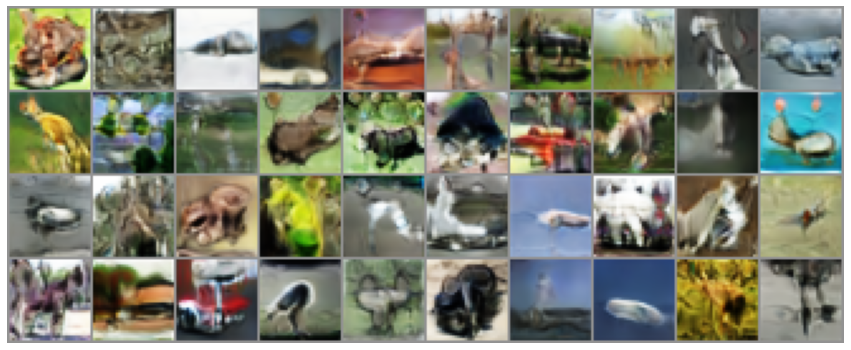

In [31]:
noise = torch.randn(40, noise_dim, device = device)

with torch.no_grad():
  fake = []
  for i in range(4):
    f = netG(noise[i*10:(i+1)*10])
    fake.append(f.cpu())
  fake = torch.cat(fake)

print(fake.shape)
grid = torchvision.utils.make_grid(fake, nrow = 10, padding = 1, pad_value = 0.15)
f = plt.figure(figsize=(15,15))
plt.imshow((grid.permute(1, 2, 0)+1)/2)
plt.axis('off')
plt.show()